In [52]:
# Load the required modules
import sys
sys.path.append("../..")
from datasetGenerator import DCASE2018
from Encoder import Encoder
from Binarizer import Binarizer

from keras.layers import GRU, Bidirectional, Layer, TimeDistributed, Dense, GRUCell
from keras.models import model_from_json, Model
from keras import backend as K
from keras import regularizers
import matplotlib.pyplot as plt
import matplotlib.patches as patch
from subprocess import call

# evaluate
from evaluation_measures import event_based_evaluation
from dcase_util.containers import MetaDataContainer

import pickle
import librosa.display
import librosa
import numpy as np
import os
import copy

In [41]:
# Load the test data create the test dataset
# load the file list
featTestPath = "/baie/corpus/DCASE2018/task4/FEATURES/test/mel"
featTestList = os.listdir(featTestPath)

# load the meta data ----
metaPath = "/baie/corpus/DCASE2018/task4/metadata/test.csv"
with open(metaPath, "r") as metaFile:
    metadata = metaFile.read().splitlines()[1:]
    
metadata = [i.split("\t") for i in metadata]

# load the features
featTest = []
for file in featTestList:
    path = os.path.join(featTestPath, file)
    feature = np.load(path)
    
    # preprocessing
    feature = np.expand_dims(feature, axis=-1)
    featTest.append(feature)
    
featTest = np.array(featTest)

# Custom implementation for GRU and GRUCell

In [2]:
class CustomGRUCell(GRUCell):

    def __init__(self, units, activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True,
                 kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros',
                 kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, kernel_constraint=None,
                 recurrent_constraint=None, bias_constraint=None, dropout=0., recurrent_dropout=0., implementation=1,
                 reset_after=False, temporal_weight: float = 0.5, **kwargs):

        self.temporal_weight = temporal_weight

        super().__init__(units, activation, recurrent_activation, use_bias, kernel_initializer, recurrent_initializer,
                         bias_initializer, kernel_regularizer, recurrent_regularizer, bias_regularizer,
                         kernel_constraint, recurrent_constraint, bias_constraint, dropout, recurrent_dropout,
                         implementation, reset_after, **kwargs)
        
        print("Temporal weight : ", self.temporal_weight)


    def call(self, inputs, states, training=None):
        h_tm1 = states[0]  # previous memory

        # if 0 < self.dropout < 1 and self._dropout_mask is None:
        #     self._dropout_mask = _generate_dropout_mask(
        #         K.ones_like(inputs),
        #         self.dropout,
        #         training=training,
        #         count=3)
        # if (0 < self.recurrent_dropout < 1 and
        #         self._recurrent_dropout_mask is None):
        #     self._recurrent_dropout_mask = _generate_dropout_mask(
        #         K.ones_like(h_tm1),
        #         self.recurrent_dropout,
        #         training=training,
        #         count=3)

        # dropout matrices for input units
        dp_mask = self._dropout_mask
        # dropout matrices for recurrent units
        rec_dp_mask = self._recurrent_dropout_mask

        if self.implementation == 1:
            if 0. < self.dropout < 1.:
                inputs_z = inputs * dp_mask[0]
                inputs_r = inputs * dp_mask[1]
                inputs_h = inputs * dp_mask[2]
            else:
                inputs_z = inputs
                inputs_r = inputs
                inputs_h = inputs

            x_z = K.dot(inputs_z, self.kernel_z)
            x_r = K.dot(inputs_r, self.kernel_r)
            x_h = K.dot(inputs_h, self.kernel_h)
            if self.use_bias:
                x_z = K.bias_add(x_z, self.input_bias_z)
                x_r = K.bias_add(x_r, self.input_bias_r)
                x_h = K.bias_add(x_h, self.input_bias_h)

                
                
                
                
                
                
                
                
            if 0. < self.recurrent_dropout < 1.:
                h_tm1_z = h_tm1 * self.temporal_weight #rec_dp_mask[0]
                h_tm1_r = h_tm1 * self.temporal_weight #rec_dp_mask[1]
                h_tm1_h = h_tm1 * self.temporal_weight #rec_dp_mask[2]
            else:
                h_tm1_z = h_tm1 * self.temporal_weight
                h_tm1_r = h_tm1 * self.temporal_weight
                h_tm1_h = h_tm1 * self.temporal_weight

                
                
                
                
                
                
            recurrent_z = K.dot(h_tm1_z, self.recurrent_kernel_z)
            recurrent_r = K.dot(h_tm1_r, self.recurrent_kernel_r)
            if self.reset_after and self.use_bias:
                recurrent_z = K.bias_add(recurrent_z, self.recurrent_bias_z)
                recurrent_r = K.bias_add(recurrent_r, self.recurrent_bias_r)

            z = self.recurrent_activation(x_z + recurrent_z)
            r = self.recurrent_activation(x_r + recurrent_r)

            # reset gate applied after/before matrix multiplication
            if self.reset_after:
                recurrent_h = K.dot(h_tm1_h, self.recurrent_kernel_h)
                if self.use_bias:
                    recurrent_h = K.bias_add(recurrent_h, self.recurrent_bias_h)
                recurrent_h = r * recurrent_h
            else:
                recurrent_h = K.dot(r * h_tm1_h, self.recurrent_kernel_h)

            hh = self.activation(x_h + recurrent_h)
        else:
            if 0. < self.dropout < 1.:
                inputs *= dp_mask[0]

            # inputs projected by all gate matrices at once
            matrix_x = K.dot(inputs, self.kernel)
            if self.use_bias:
                # biases: bias_z_i, bias_r_i, bias_h_i
                matrix_x = K.bias_add(matrix_x, self.input_bias)
            x_z = matrix_x[:, :self.units]
            x_r = matrix_x[:, self.units: 2 * self.units]
            x_h = matrix_x[:, 2 * self.units:]

            if 0. < self.recurrent_dropout < 1.:
                h_tm1 *= rec_dp_mask[0]

            if self.reset_after:
                # hidden state projected by all gate matrices at once
                matrix_inner = K.dot(h_tm1, self.recurrent_kernel)
                if self.use_bias:
                    matrix_inner = K.bias_add(matrix_inner, self.recurrent_bias)
            else:
                # hidden state projected separately for update/reset and new
                matrix_inner = K.dot(h_tm1,
                                     self.recurrent_kernel[:, :2 * self.units])

            recurrent_z = matrix_inner[:, :self.units]
            recurrent_r = matrix_inner[:, self.units: 2 * self.units]

            z = self.recurrent_activation(x_z + recurrent_z)
            r = self.recurrent_activation(x_r + recurrent_r)

            if self.reset_after:
                recurrent_h = r * matrix_inner[:, 2 * self.units:]
            else:
                recurrent_h = K.dot(r * h_tm1,
                                    self.recurrent_kernel[:, 2 * self.units:])

            hh = self.activation(x_h + recurrent_h)

        # previous and candidate state mixed by update gate
        h = z * h_tm1 + (1 - z) * hh

        if 0 < self.dropout + self.recurrent_dropout:
            if training is None:
                h._uses_learning_phase = True

        return h, [h]


class CustomGRU(GRU):

    def __init__(self, units, activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True,
                 kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros',
                 kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None,
                 kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.,
                 recurrent_dropout=0., implementation=1, return_sequences=False, return_state=False, go_backwards=False,
                 stateful=False, unroll=False, reset_after=False, temporal_weight: float = 0.5, **kwargs):

        """
        super().__init__(units, activation=activation, recurrent_activation=recurrent_activation,
                         use_bias=use_bias, kernel_initializer=kernel_initializer, recurrent_initializer=recurrent_initializer,
                         bias_initializer=bias_initializer, kernel_regularizer=kernel_regularizer,
                         recurrent_regularizer=recurrent_regularizer, bias_regularizer=bias_regularizer,
                         activity_regularizer=activity_regularizer, kernel_constraint=kernel_constraint,
                         recurrent_constraint=recurrent_constraint, bias_constraint=bias_constraint,
                         dropout=dropout, recurrent_dropout=recurrent_dropout, implementation=implementation,
                         return_sequences=return_sequences, return_state=return_state, go_backwards=go_backwards,
                         stateful=stateful, unroll=unroll, reset_after=reset_after, **kwargs)
        """
        
        self.temporal_weight = temporal_weight

        cell = CustomGRUCell(units,
                       activation=activation,
                       recurrent_activation=recurrent_activation,
                       use_bias=use_bias,
                       kernel_initializer=kernel_initializer,
                       recurrent_initializer=recurrent_initializer,
                       bias_initializer=bias_initializer,
                       kernel_regularizer=kernel_regularizer,
                       recurrent_regularizer=recurrent_regularizer,
                       bias_regularizer=bias_regularizer,
                       kernel_constraint=kernel_constraint,
                       recurrent_constraint=recurrent_constraint,
                       bias_constraint=bias_constraint,
                       dropout=dropout,
                       recurrent_dropout=recurrent_dropout,
                       implementation=implementation,
                       reset_after=reset_after,
                       temporal_weight=temporal_weight)

        super(GRU, self).__init__(cell,
                                  return_sequences=return_sequences,
                                  return_state=return_state,
                                  go_backwards=go_backwards,
                                  stateful=stateful,
                                  unroll=unroll,
                                  **kwargs)
        self.activity_regularizer = regularizers.get(activity_regularizer)

        
        
        
    def get_config(self):
        config = super().get_config()
        config["temporal_weight"] = self.temporal_weight
        return config
        
    def call(self, inputs, mask=None, training=None, initial_state=None):
        return super().call(inputs, mask, True, initial_state)
        
    

# Load the model

In [49]:
modelJsonPath = "/homeLocal/eriador/Documents/DCASE2018/results/testing/mel_old_noBlank_timeReduction2/oldMel_noBlank_reduce2_model.json"
modelWeightPath = "/homeLocal/eriador/Documents/DCASE2018/results/testing/mel_old_noBlank_timeReduction2/oldMel_noBlank_reduce2_weight.h5py"

# With GRU and TimeDistributed
## Remove the GlobalAveragePooling1D to trace score per frames

In [44]:
##### load the model and perform prediction
K.clear_session()

with open(modelJsonPath, "r") as modelJsonFile:
    model = model_from_json(modelJsonFile.read())
model.load_weights(modelWeightPath)

#disasemble layers
layers = [l for l in model.layers]

# Get the trained forward layer from the bidirectional and change it's property
b1 = model.get_layer("bidirectional_1")

x = layers[0].output
for i in range(1, len(layers)):
    if layers[i].name == "bidirectional_1":
        x = Bidirectional(
            GRU(units=64, kernel_initializer='glorot_uniform', recurrent_dropout=0.8, dropout=0.0, return_sequences=True))(x)
    elif layers[i].name == "time_distributed_1":
        x = TimeDistributed( Dense(10, activation="sigmoid"), )(x)
    else:
        x = layers[i](x)

newModel = Model(input=layers[0].input, output=x)
newModel.load_weights(modelWeightPath)
#model.summary()

intermediate_model = Model(input=model.input, output=newModel.get_layer("time_distributed_1").output)
#intermediate_model.summary()


# retreive information about the custom
prediction = intermediate_model.predict(featTest)
print("done")

/homeLocal/eriador/.miniconda3/envs/dcase/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("gl...)`
/homeLocal/eriador/.miniconda3/envs/dcase/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ti...)`


done


# With ***Custom*** GRU and TimeDistributed
## Remove the GlobalAveragePooling1D to trace score per frames

In [37]:
##### load the model and perform prediction
K.clear_session()

with open(modelJsonPath, "r") as modelJsonFile:
    model = model_from_json(modelJsonFile.read())
model.load_weights(modelWeightPath)

#disasemble layers
layers = [l for l in model.layers]

# Get the trained forward layer from the bidirectional and change it's property
b1 = model.get_layer("bidirectional_1")

x = layers[0].output
for i in range(1, len(layers)):
    if layers[i].name == "bidirectional_1":
        x = Bidirectional(
            CustomGRU(units=64, kernel_initializer='glorot_uniform', recurrent_dropout=0.8, dropout=0.0, return_sequences=True, temporal_weight=0.25), name="custom_bi")(x)
    elif layers[i].name == "time_distributed_1":
        x = TimeDistributed( Dense(10, activation="sigmoid"), )(x)
    else:
        x = layers[i](x)

newModel = Model(input=layers[0].input, output=x)
newModel.load_weights(modelWeightPath)
#model.summary()

intermediate_model = Model(input=model.input, output=newModel.get_layer("time_distributed_1").output)
#intermediate_model.summary()


# retreive information about the custom
prediction = intermediate_model.predict(featTest)
print("done")

Temporal weight :  0.25
Temporal weight :  0.25


/homeLocal/eriador/.miniconda3/envs/dcase/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("gl...)`
/homeLocal/eriador/.miniconda3/envs/dcase/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ti...)`


done


# Load the dataset

In [43]:
# load the dataset
featRoot = "/baie/corpus/DCASE2018/task4/FEATURES"
metaRoot = "/baie/corpus/DCASE2018/task4/metadata"
feat =  ["mel"]
normalizer = None

dataset = DCASE2018(
        featureRoot=featRoot,
        metaRoot=metaRoot,
        features=feat,
        expandWithUod=False,
        validationPercent=0.2,
        normalizer=normalizer
    )

SyntaxError: EOL while scanning string literal (<ipython-input-43-e1ccc016f2b9>, line 2)

# Display method
### Draw score over time for each classes.
### Draw boudaries from ground truth

In [82]:
# process the prediction (intermediate model)
nbFileToDisplay = 4
boundaries = True

classes = "time,Alarm_bell_ringing,Speech,Dog,Cat,Vacuum_cleaner,Dishes,Frying,Electric_shaver_toothbrush,Blender,Running_water".split(",")
output = "time,Alarm_bell_ringing,Speech,Dog,Cat,Vacuum_cleaner,Dishes,Frying,Electric_shaver_toothbrush,Blender,Running_water\n"
Colors = "C0,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,#c2c2c2".split(",")

nbFrame = prediction.shape[1]
frameLength = 10 / nbFrame

def getClasses(file):
    output = ""
    for info in metadata:
        if info[0] == file[:-4]:
            output += ",".join(info[1:]) + "\n"
            
    return output
    
    
def display(filePath, patches: str = "test", encoded = None, curve: str = None):
    def patchFromStr():
        # add patches to highlight ground truth
        tBoundaries = rawBoundaries.split("\n")
        for line in tBoundaries:
            info = line.split(",")
            if len(info) == 3:
                if curve is not None:
                    if info[-1] == toDisplay:

                        color = Colors[classes.index(info[2])]
                        start = float(info[0])
                        end = float(info[1]) - float(info[0])
                        rect = patch.Rectangle(
                            (start,0),end,1,
                            linewidth=1,
                            edgecolor=color,
                            facecolor=color,
                            alpha=0.08)

                        ax.add_patch(rect)
                else:
                    color = Colors[classes.index(info[2])]
                    start = float(info[0])
                    end = float(info[1]) - float(info[0])
                    rect = patch.Rectangle(
                        (start,0),end,1,
                        linewidth=1,
                        edgecolor=color,
                        facecolor=color,
                        alpha=0.08)

                    ax.add_patch(rect)
                
    def patchFromEncoder(encoded: dict):
        for cls in encoded:
            start = 0
            for segment in encoded[cls]:
                # if empty, pass to the next
                if len(segment) == 0:
                    continue
                
                if segment[0] == 1:      # Only for positive segment
                    color = Colors[cls+1]
                    end = (segment[1] * frameLength)
                    rect = patch.Rectangle((start * frameLength, 0), end, 5, linewidth=1, edgecolor=color, facecolor=color, alpha=0.25)
                    ax.add_patch(rect)
                    print("start: ", start, "rect : ", rect)
                    start += segment[1]
                
                else:
                    start += segment[1]
                    
        

    with open(filePath, "r") as f:
        raw = f.readlines()[1:]
    data = []
    for r in raw:
        data.append(r[:-1].split(","))
        
    data = np.array(data)
    time = np.array(data[:,0], np.float32)
    alarm = np.array(data[:,1], np.float32)
    speech = np.array(data[:,2], np.float32)
    dog = np.array(data[:,3], np.float32)
    cat = np.array(data[:,4], np.float32)
    vac = np.array(data[:,5], np.float32)
    dishes = np.array(data[:,6], np.float32)
    frying = np.array(data[:,7], np.float32)
    elec = np.array(data[:,8], np.float32)
    blend = np.array(data[:,9], np.float32)
    run = np.array(data[:,10], np.float32)
    #blk = np.array(data[:,11], np.float32)
    
    fig, ax = plt.subplots(1, figsize=(18,6))
    plt.title(filePath)
    if curve is None:
        ax.plot(time, alarm, label="alarm", color=Colors[classes.index("Alarm_bell_ringing")])
        ax.plot(time, speech, label="speech", color=Colors[classes.index("Speech")])
        ax.plot(time, dog, label="dog", color=Colors[classes.index("Dog")])
        ax.plot(time, cat, label="cat", color=Colors[classes.index("Cat")])
        ax.plot(time, vac, label="vac", color=Colors[classes.index("Vacuum_cleaner")])
        ax.plot(time, dishes, label="dishes", color=Colors[classes.index("Dishes")])
        ax.plot(time, frying, label="frying", color=Colors[classes.index("Frying")])
        ax.plot(time, elec, label="elec", color=Colors[classes.index("Electric_shaver_toothbrush")])
        ax.plot(time, blend, label="blend", color=Colors[classes.index("Blender")])
        ax.plot(time, run, label="run", color=Colors[classes.index("Running_water")])
    
    else:
        toPlot = np.array(data[:,DCASE2018.class_correspondance[curve]], np.float32)
        ax.plot(time, toPlot, label=curve, color=Colors[classes.index(curve)])
        
    #ax.plot(time, blk, label="blk", color=Colors[classes.index("blank")])
    ax.legend(loc="upper right")
    
    # add patches to highlight ground truth
    if patches == "test": patchFromStr()
    elif patches == "encoder": patchFromEncoder(encoded)
    
    plt.show()

# Choose witch class to analysis

In [87]:
import pandas as pd
toDisplay = "Dishes"

test_df = pd.read_csv("../../meta/test.csv", sep="\t")

fileToAnalyse = test_df.loc[test_df.event_label == toDisplay].filename.values
fileToAnalyse = np.unique(fileToAnalyse)
fileToAnalyse, 

(array(['Y-YmyB631yvU_40.000_50.000.wav',
        'Y-z9G9RrH9so_320.000_330.000.wav',
        'Y19UacScA26s_70.000_80.000.wav',
        'Y1NYJAJXYyNY_350.000_360.000.wav',
        'Y1NbotQwFUTg_30.000_40.000.wav',
        'Y1QK5WA4dK4o_400.000_410.000.wav',
        'Y1WdoejoSGj8_60.000_70.000.wav', 'Y21u5DMRvEhs_30.000_40.000.wav',
        'Y2DF8mtDke8k_460.000_470.000.wav',
        'Y2R7p_Ac26mU_30.000_40.000.wav',
        'Y3eN7ujFJzXQ_170.000_180.000.wav',
        'Y4Yo_DkHXXjI_170.000_180.000.wav',
        'Y4e0riwTv0xY_170.000_180.000.wav',
        'Y4nv-GOe3h54_110.000_120.000.wav',
        'Y5J603SAj7QM_210.000_220.000.wav',
        'Y5aSyIbD6jY4_70.000_80.000.wav',
        'Y5dmvNaIHaBA_350.000_360.000.wav',
        'Y5iT-5fccnC8_70.000_80.000.wav',
        'Y5qx1HGIWJww_170.000_180.000.wav',
        'Y6kKs7UKCUBA_70.000_80.000.wav', 'Y9V-F5sW1vk8_20.000_30.000.wav',
        'Y9m96yRfGJ1I_150.000_160.000.wav',
        'Y9mdHUoBmtiE_0.000_10.000.wav',
        'Y9xFa6pE7120_270.0

# Can also load thomas prediction (pkl files)

In [89]:
# Load the pkl file
with open('dico_10epochs_MIL_cnn_classif_cnn_100epochs_f1_0.8584_valf1_0.8286.pkl', 'rb') as f:
    data = pickle.load(f)
    
# convert to a readable format

testListFile = [f[:-8] for f in dataset.testFileList]
nbFrame = 431

# rearange list of results
results = []
lfn = []
for f in testListFile:
    info = data[f]
    
    curves = np.array([[0]*dataset.nbClass for _ in range(nbFrame)], dtype=np.float32)
    
    for cls in info:
        index = DCASE2018.class_correspondance[cls]
        curves[:,index] = info[cls]
        
    results.append(curves)
    lfn.append(f)

prediction = np.array(results)

# Or temporal prediction from npy files

In [94]:
prediction = np.load("temporal_prediction.npy")

# Display the choosen file with their ground truth

Y1NYJAJXYyNY_350.000_360.000.wav.npy
0.483,10.0,Frying
1.354,2.233,Speech
4.041,5.037,Speech
7.513,7.763999999999999,Dishes
9.047,9.676,Dishes



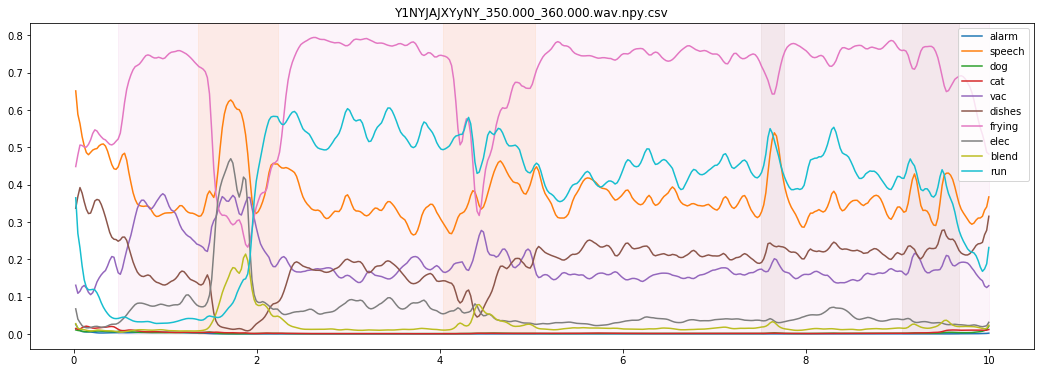

Y3eN7ujFJzXQ_170.000_180.000.wav.npy
0.0,10.0,Frying
2.36,2.7960000000000003,Dishes
3.0989999999999998,4.68,Speech
3.8689999999999998,4.638999999999999,Dishes
5.43,7.617000000000001,Speech
8.488,9.988,Speech



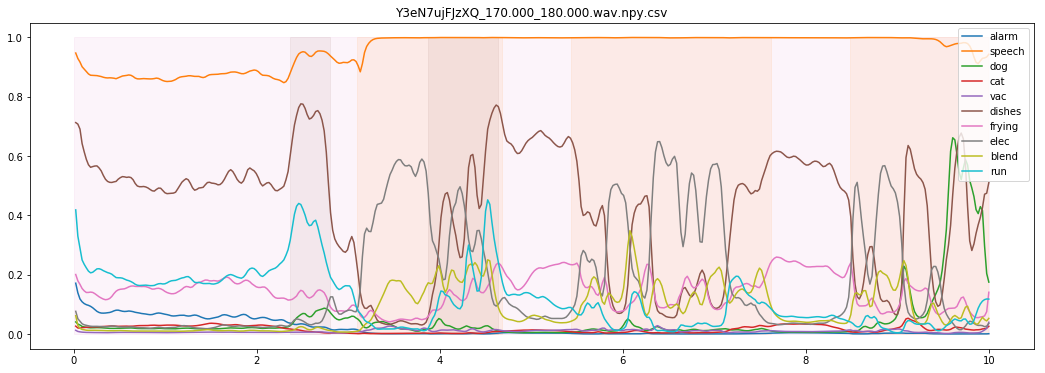

Y-z9G9RrH9so_320.000_330.000.wav.npy
0.473,1.079,Dishes
1.3419999999999999,1.604,Dishes
1.777,2.778,Speech
2.761,5.796,Blender
5.343,9.524,Speech



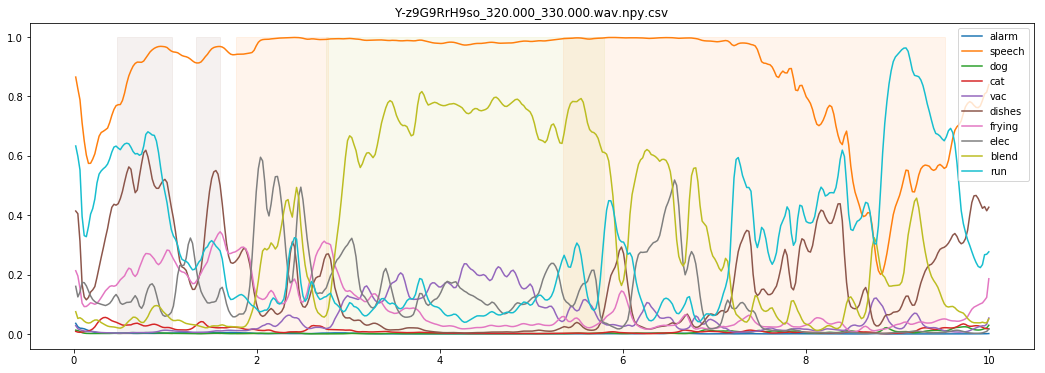

Y9mdHUoBmtiE_0.000_10.000.wav.npy
0.0,10.0,Frying
0.565,0.815,Dishes
5.113,8.044,Speech



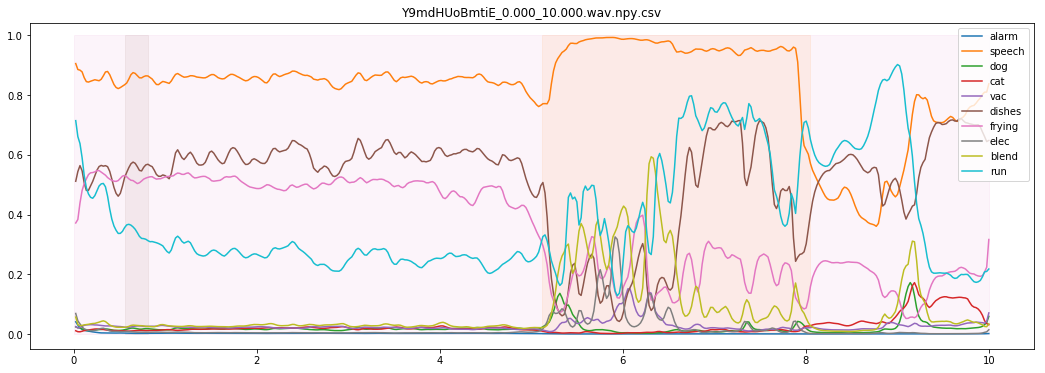

Y5J603SAj7QM_210.000_220.000.wav.npy
0.0,10.0,Frying
0.32799999999999996,0.578,Dishes
0.8390000000000001,1.089,Dishes
1.86,2.198,Dishes
3.008,3.258,Dishes
3.574,3.824,Dishes
4.489,5.974,Dishes
6.265,6.899,Dishes
9.068,10.0,Speech



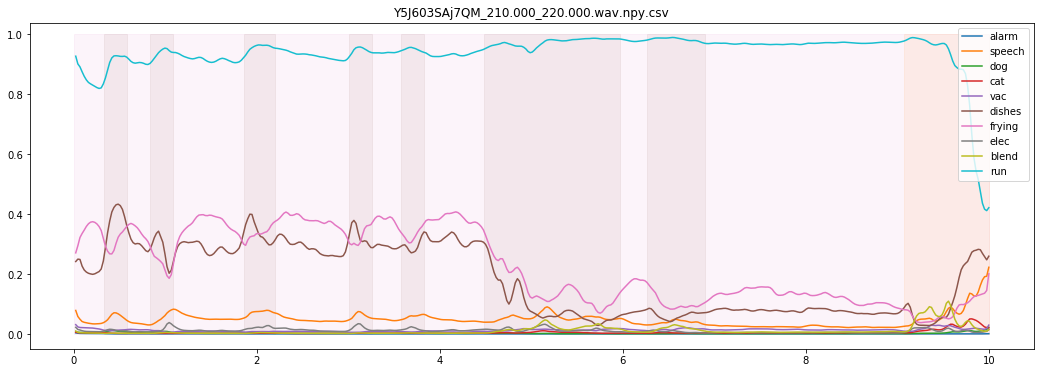

Y1QK5WA4dK4o_400.000_410.000.wav.npy
0.0,0.25,Dishes
0.45,0.938,Dishes
1.131,1.844,Dishes
1.9969999999999999,2.878,Dishes
3.0469999999999997,4.008,Dishes
4.743,5.656000000000001,Dishes
6.011,6.261,Dishes
7.317,8.126,Dishes



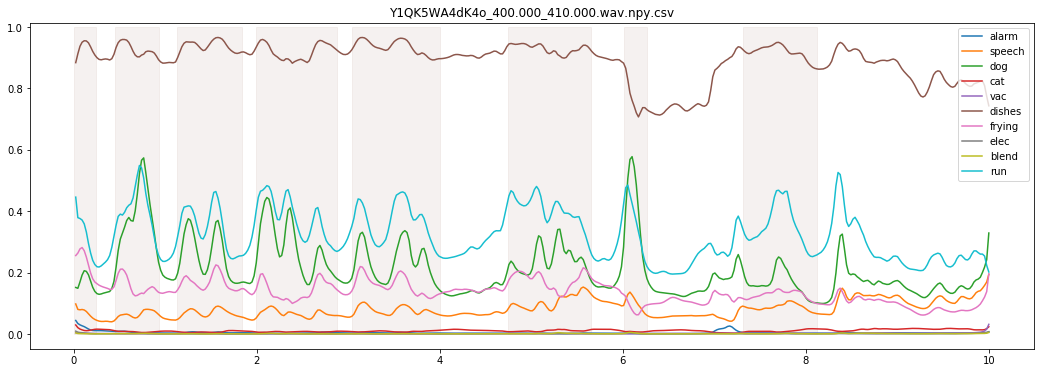

Y-YmyB631yvU_40.000_50.000.wav.npy
0.0,1.425,Speech
3.242,3.753,Dishes
3.806,5.443,Speech
4.626,5.4510000000000005,Dishes
6.075,9.828,Speech
7.506,7.928,Dishes



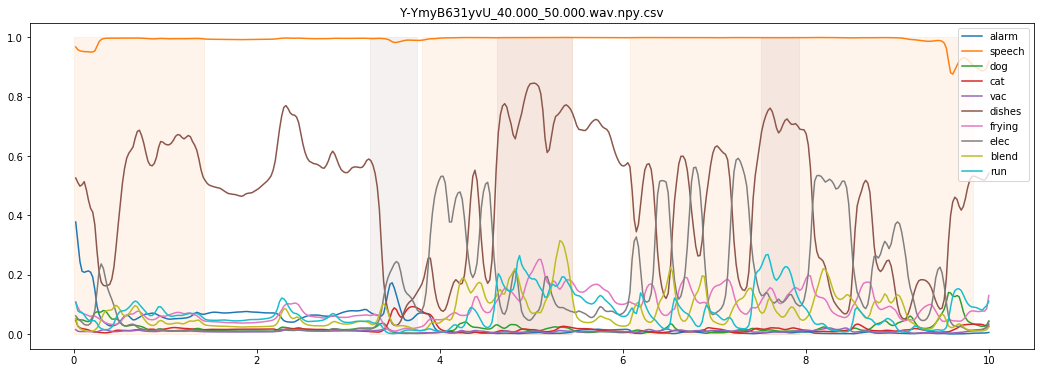

YIuKYDovQ79I_350.000_360.000.wav.npy
0.9990000000000001,1.663,Speech
2.28,3.737,Speech
2.761,3.602,Dishes
4.313,5.564,Speech
6.434,7.015,Dishes
7.82,8.812999999999999,Speech
9.307,10.0,Speech



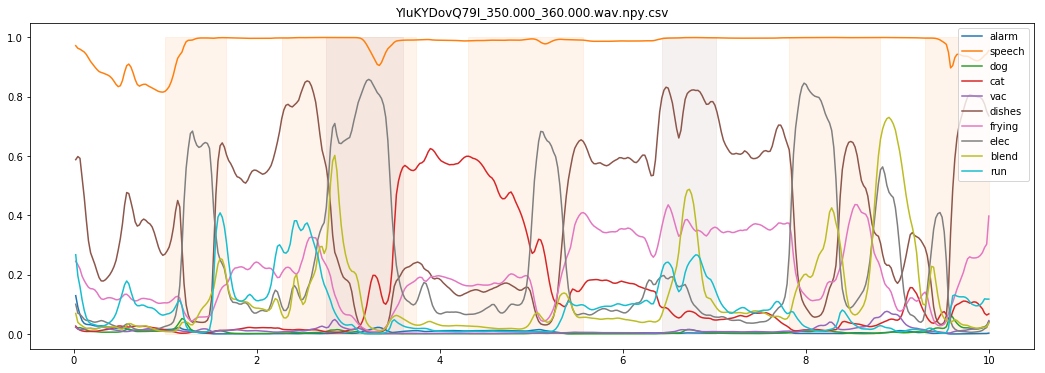

Y4Yo_DkHXXjI_170.000_180.000.wav.npy
0.0,0.542,Speech
0.0,6.325,Frying
0.7190000000000001,1.3980000000000001,Speech
1.845,3.843,Speech
1.933,2.533,Dishes
5.278,10.0,Speech
7.204,7.54,Dishes



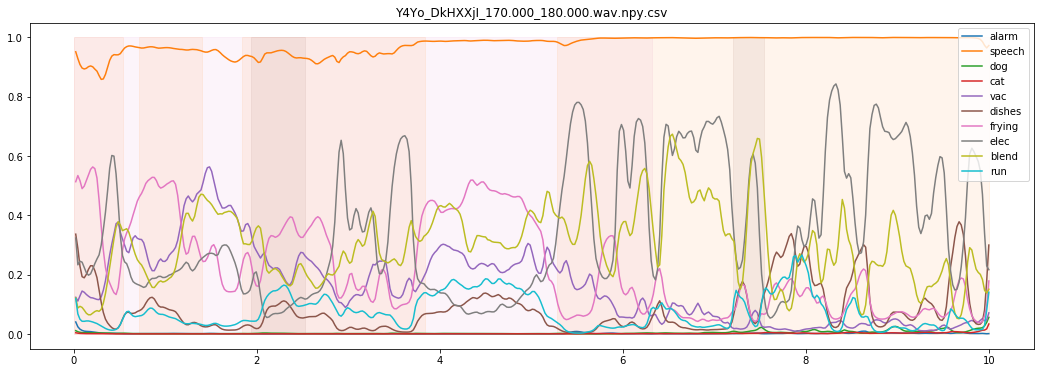

Y2R7p_Ac26mU_30.000_40.000.wav.npy
3.9560000000000004,4.309,Dishes
4.541,7.917999999999999,Dishes
8.418,8.771,Dishes



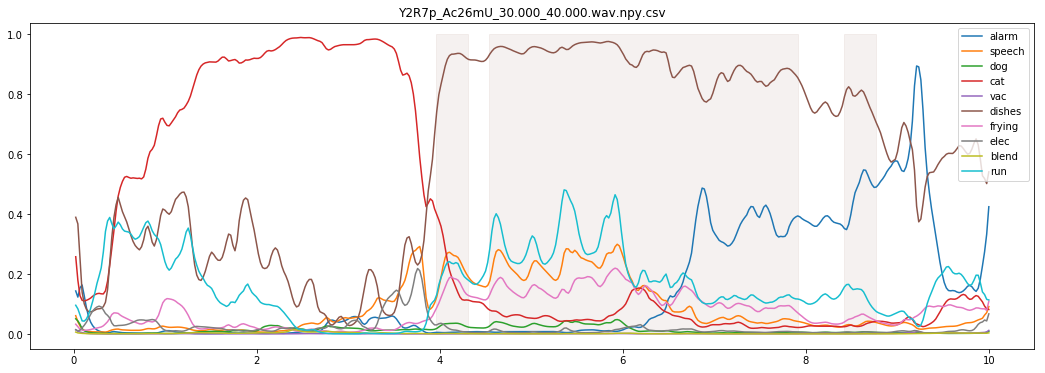

Y1NbotQwFUTg_30.000_40.000.wav.npy
0.32299999999999995,1.375,Dishes
1.851,2.4619999999999997,Dishes
2.115,10.0,Running_water
2.8080000000000003,3.137,Dishes
3.478,3.8539999999999996,Dishes
5.071000000000001,6.14,Dishes
6.586,9.624,Dishes



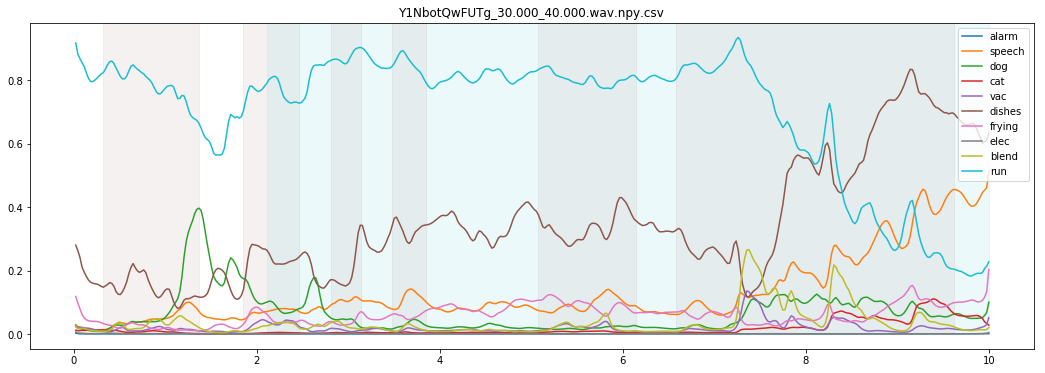

YJg1jycR1zGQ_30.000_40.000.wav.npy
0.0,0.5479999999999999,Speech
0.0,10.0,Running_water
1.8230000000000002,2.6660000000000004,Speech
2.839,3.4389999999999996,Dishes
3.716,4.16,Dishes
4.53,5.978,Dishes
5.545,6.255,Speech
7.357,10.0,Speech
7.767,8.777000000000001,Dishes



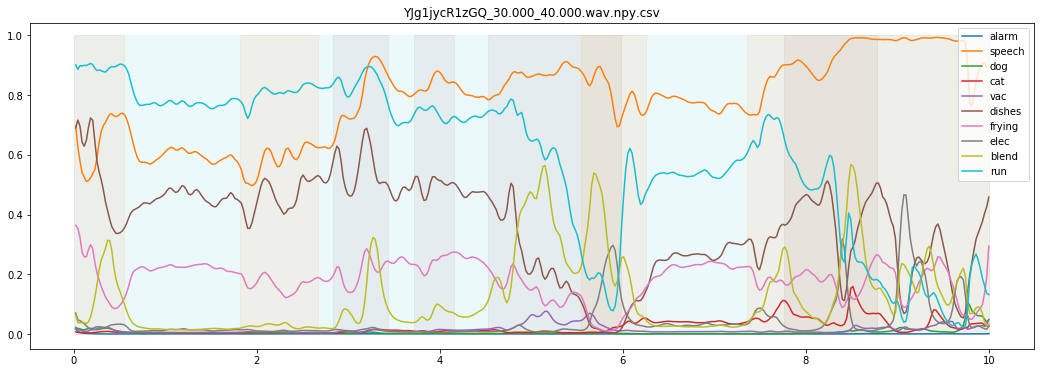

Y4nv-GOe3h54_110.000_120.000.wav.npy
0.0,0.92,Speech
0.0,9.984,Frying
2.862,3.557,Speech
3.563,3.872,Dishes
9.207,9.997,Speech



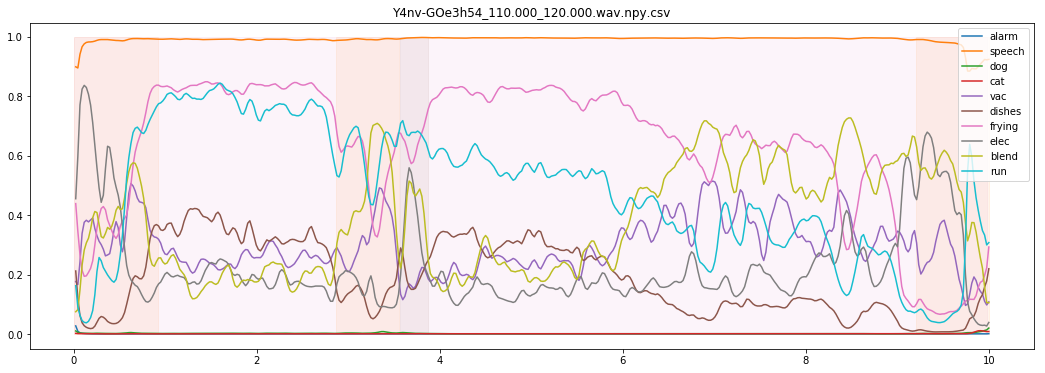

Y9V-F5sW1vk8_20.000_30.000.wav.npy
0.0,9.988,Blender
0.5529999999999999,1.176,Dishes
1.694,2.194,Dishes
5.224,5.4879999999999995,Dishes



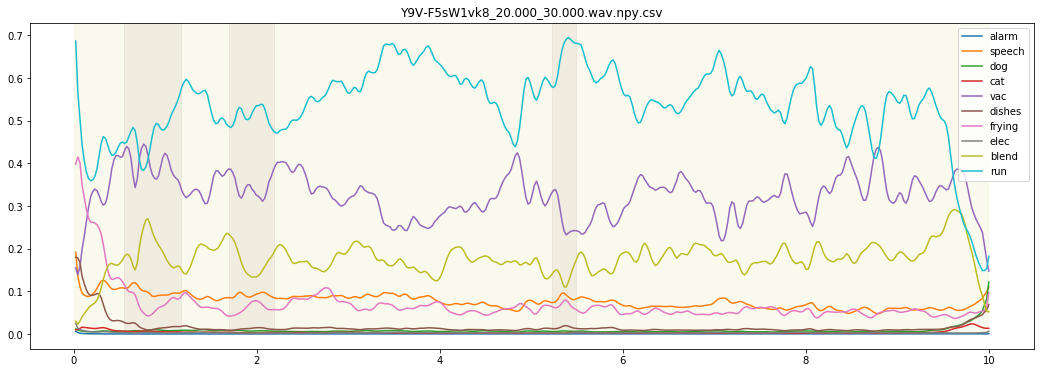

Y6kKs7UKCUBA_70.000_80.000.wav.npy
0.0,10.0,Frying
0.282,0.532,Dishes
4.048,4.33,Dishes
7.925,8.371,Dishes



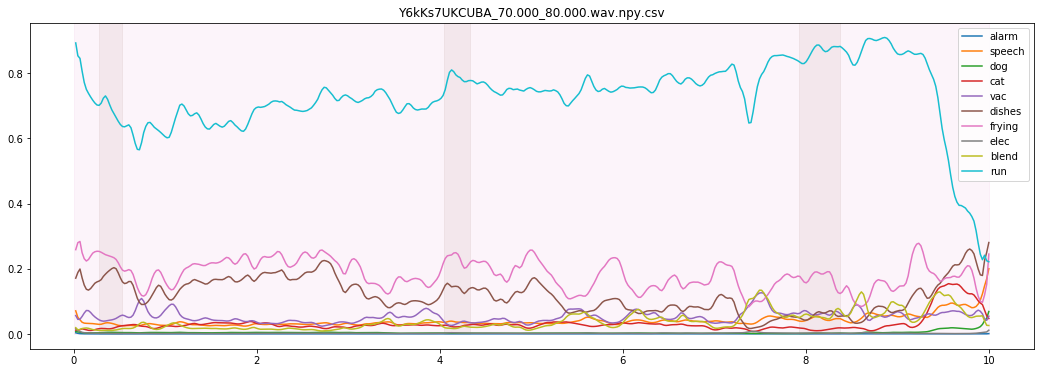

Y9m96yRfGJ1I_150.000_160.000.wav.npy
0.435,0.812,Speech
0.812,1.4569999999999999,Dishes
2.747,3.17,Speech
4.465,5.852,Speech
6.886,8.173,Speech
8.196,8.978,Dishes
9.465,9.953,Dishes



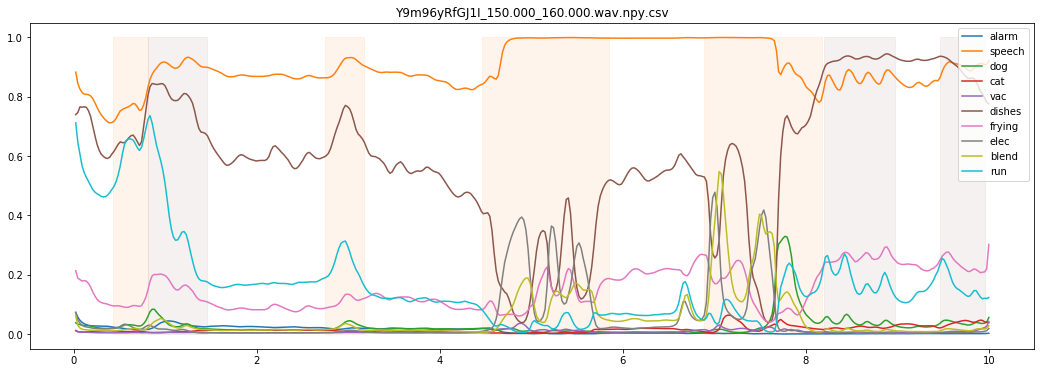

Y5aSyIbD6jY4_70.000_80.000.wav.npy
0.0,3.6319999999999997,Blender
3.86,4.871,Blender
7.766,8.45,Dishes
9.675,10.0,Speech



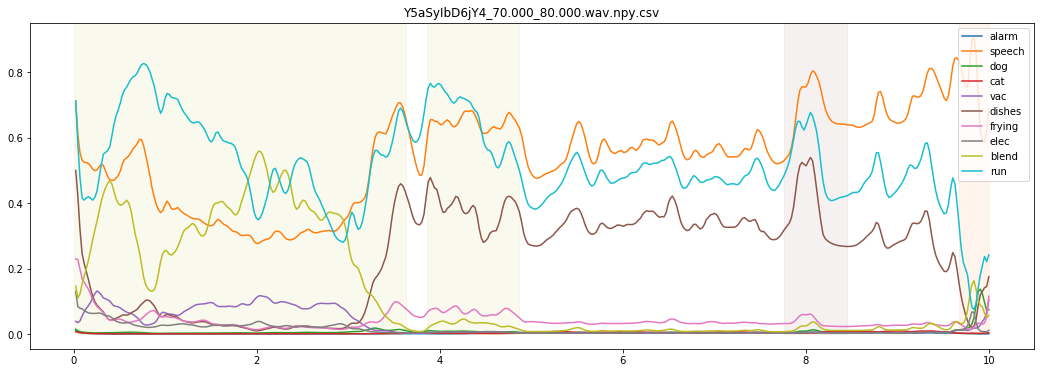

YDcuiRMRt1gs_30.000_40.000.wav.npy
0.0,10.0,Frying
4.334,4.749,Dishes
8.373,8.967,Dishes
9.261000000000001,9.561,Dishes



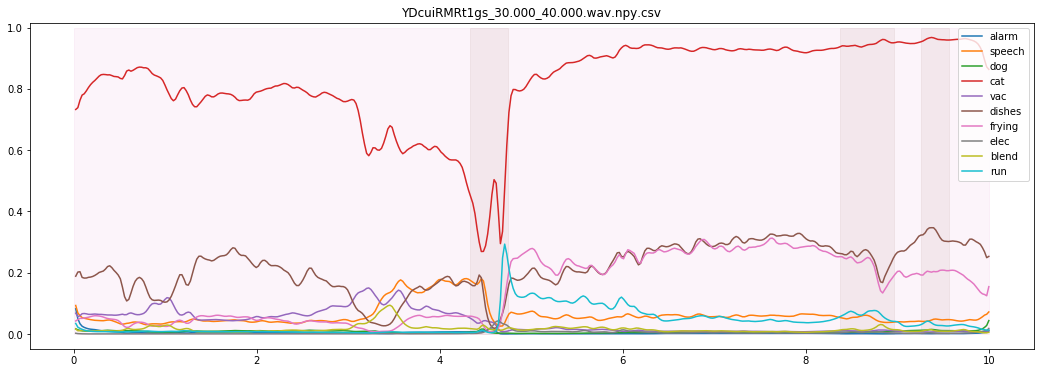

Y5dmvNaIHaBA_350.000_360.000.wav.npy
2.7310000000000003,3.77,Dishes
3.975,4.5680000000000005,Dishes
6.984,8.062000000000001,Speech
8.865,9.832,Dishes
9.215,10.0,Speech



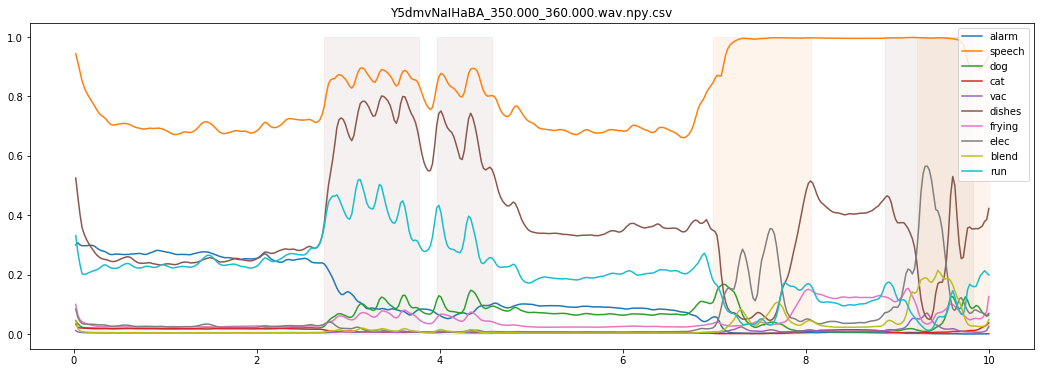

Y4e0riwTv0xY_170.000_180.000.wav.npy
0.406,1.176,Speech
0.667,1.0590000000000002,Dishes
2.318,2.806,Dishes
3.4,3.947,Speech
4.312,4.824,Speech
4.853,5.318,Dishes
5.994,6.359,Dishes
6.806,7.376,Speech



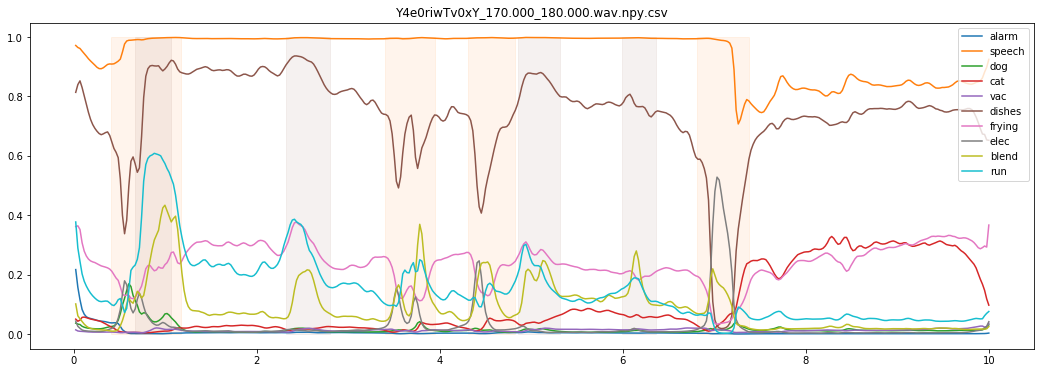

YAXpA_dWErVc_530.000_540.000.wav.npy
0.0,10.0,Frying
7.034,7.68,Dishes
7.986000000000001,8.367,Dishes
8.785,9.162,Dishes
9.502,9.781,Dishes



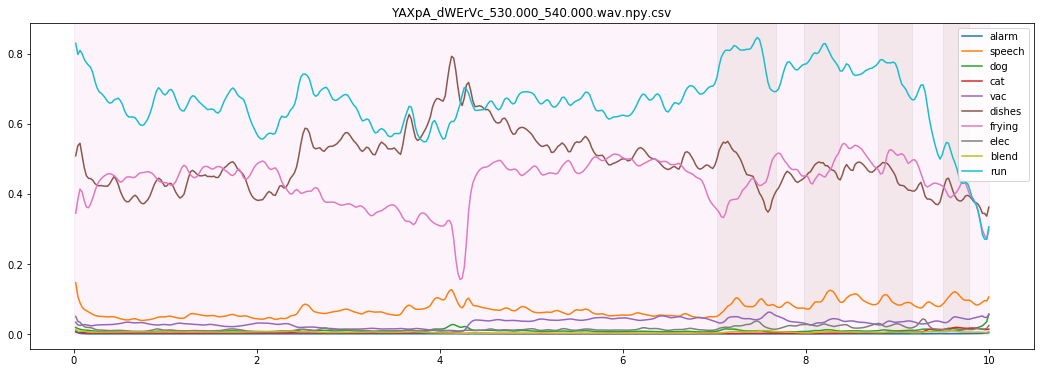

YBQ7Nj7WJL8U_70.000_80.000.wav.npy
0.0,0.67,Speech
2.568,3.1319999999999997,Dishes
4.189,4.439,Dishes
4.289,4.824,Speech
4.994,5.244,Dishes
6.257000000000001,6.557,Dishes
7.256,7.506,Dishes
7.591,8.026,Speech
7.709,7.983,Dishes
8.437000000000001,8.738,Dishes
9.197000000000001,10.0,Speech



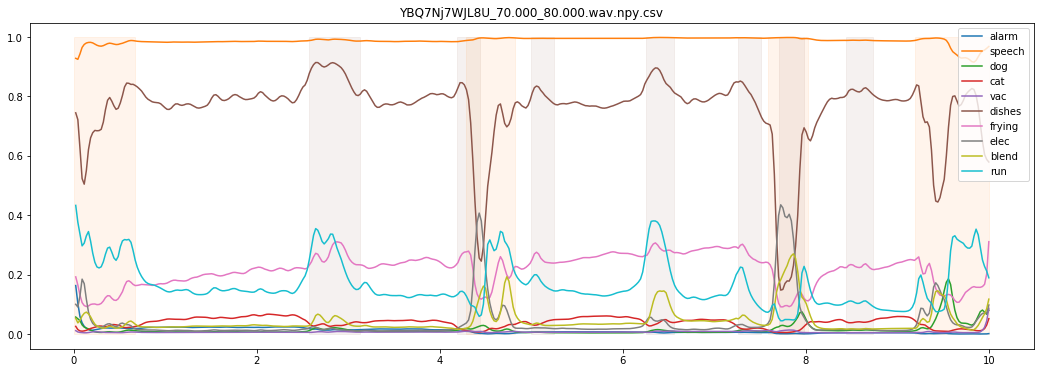

YK0OM1kMgtek_30.000_40.000.wav.npy
0.956,1.275,Dishes
1.9169999999999998,2.387,Dishes



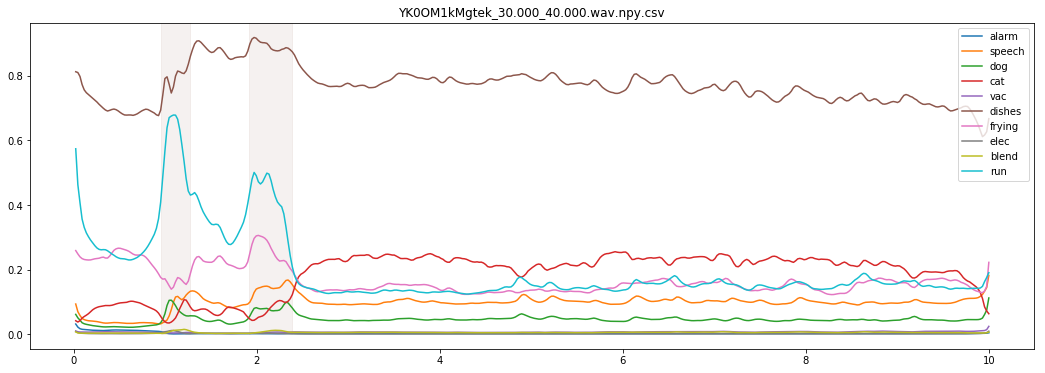

YAwjEqHYHp7I_110.000_120.000.wav.npy
0.0,2.352,Speech
2.827,7.939,Speech
3.147,9.972000000000001,Frying
3.737,4.239,Dishes
6.675,6.96,Dishes
8.468,9.99,Speech



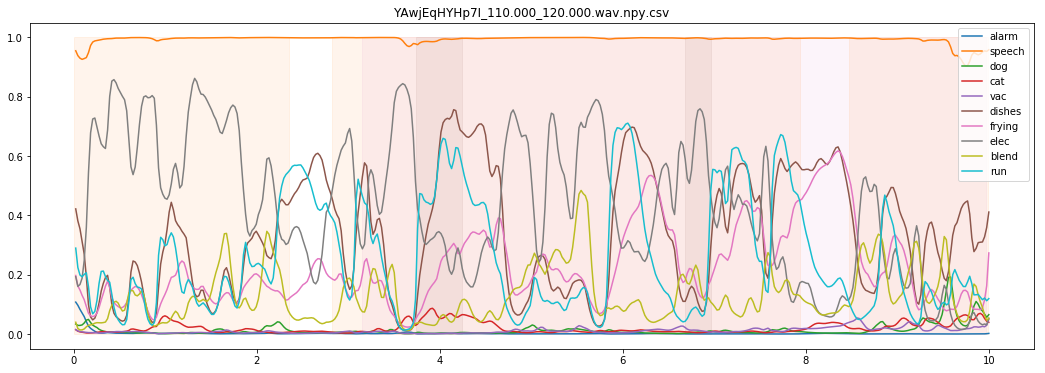

Y5qx1HGIWJww_170.000_180.000.wav.npy
0.0,0.8759999999999999,Speech
0.905,1.329,Dishes
1.484,1.766,Dishes
1.766,2.594,Speech
1.965,10.0,Frying
2.5869999999999997,2.8369999999999997,Dishes
2.5869999999999997,3.352,Dishes
2.945,3.352,Dishes
3.5069999999999997,3.9189999999999996,Dishes
3.6460000000000004,5.295,Speech
4.598,4.874,Dishes
5.4,5.795,Dishes
5.4,6.218999999999999,Dishes
5.888,6.218999999999999,Dishes
6.787999999999999,7.077999999999999,Dishes
7.914,8.45,Dishes
8.619,9.402000000000001,Dishes



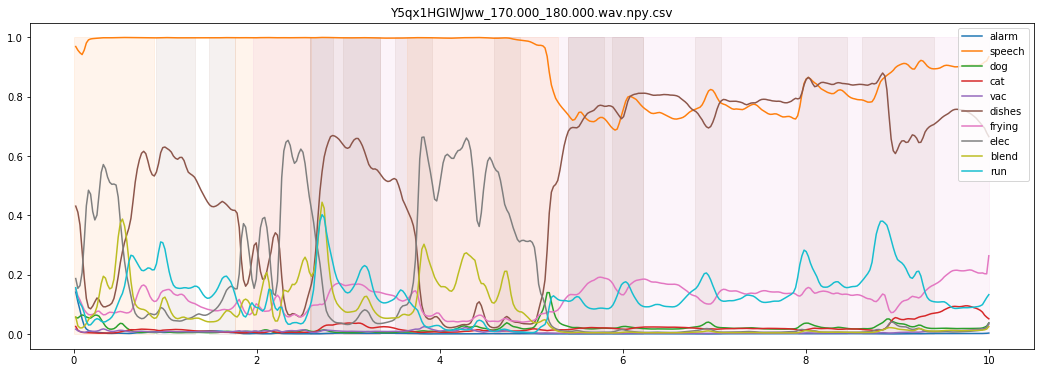

Y9xFa6pE7120_270.000_280.000.wav.npy
0.0,10.0,Frying
0.15,3.6180000000000003,Speech
3.139,3.428,Dishes
5.28,5.551,Dishes
5.665,6.601,Speech
7.242000000000001,7.582000000000001,Speech
8.244,9.911,Speech



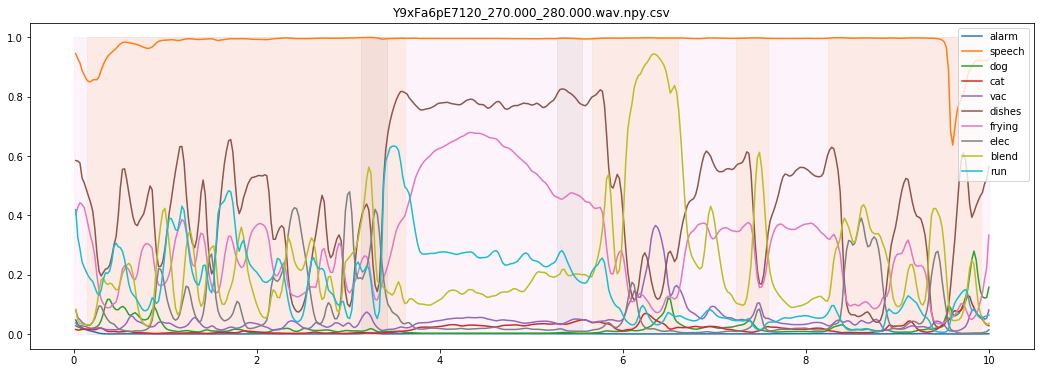

Y19UacScA26s_70.000_80.000.wav.npy
0.0,1.7630000000000001,Dishes
2.432,3.5610000000000004,Dishes
3.878,4.128,Dishes



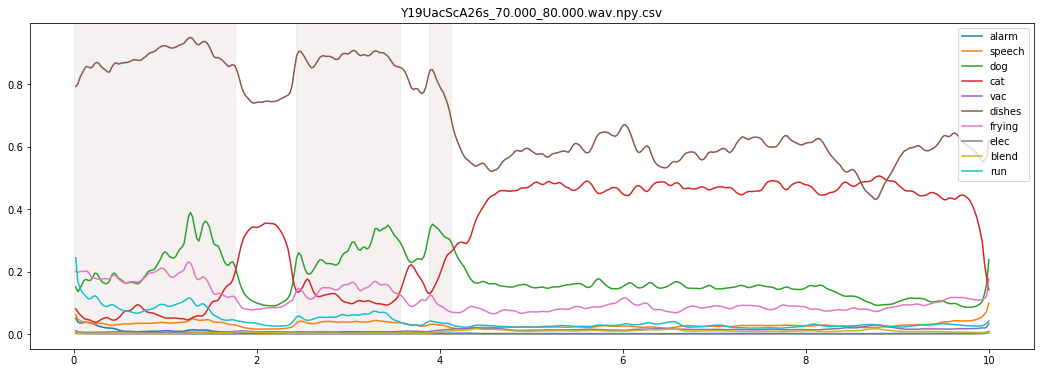

YAyl4EbZXANQ_280.000_290.000.wav.npy
0.0,4.593,Blender
5.205,8.956,Speech
7.49,8.187999999999999,Dishes



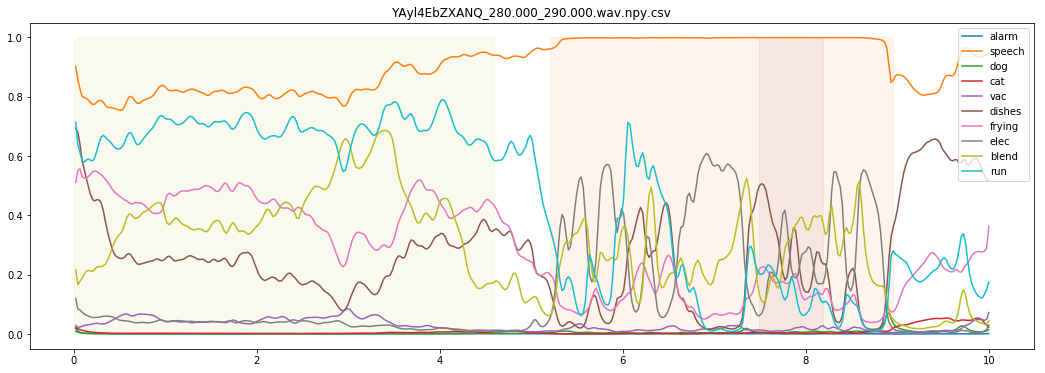

Y5iT-5fccnC8_70.000_80.000.wav.npy
0.0,9.959,Vacuum_cleaner
0.312,0.6409999999999999,Dishes



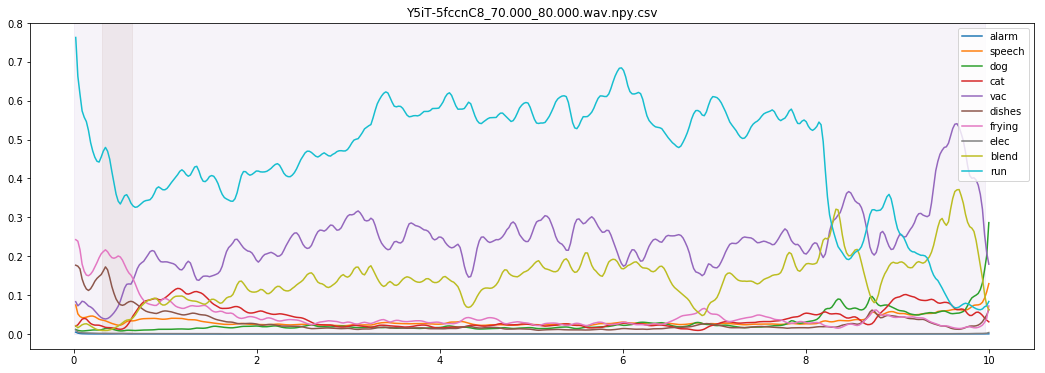

YE31PuovQDic_380.000_390.000.wav.npy
0.0,10.0,Frying
3.555,4.16,Dishes
7.484,8.055,Dishes



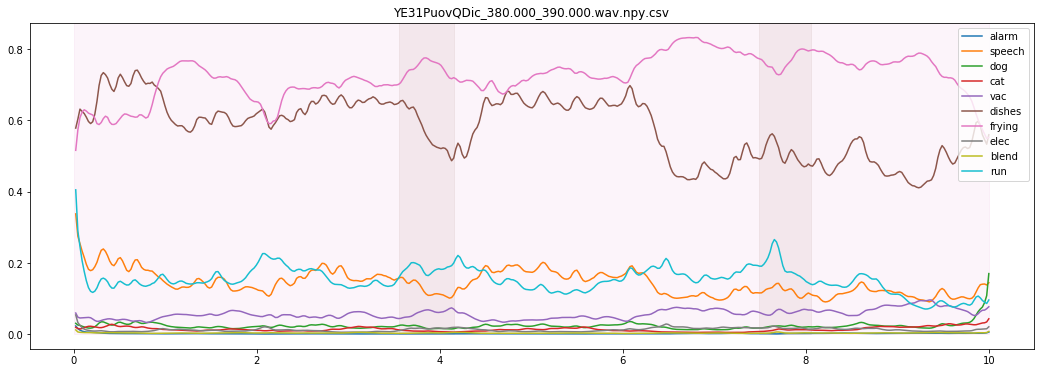

Y1WdoejoSGj8_60.000_70.000.wav.npy
0.0,10.0,Frying
1.713,2.006,Dishes
3.616,3.866,Dishes
4.151,4.436,Dishes
4.685,4.985,Dishes



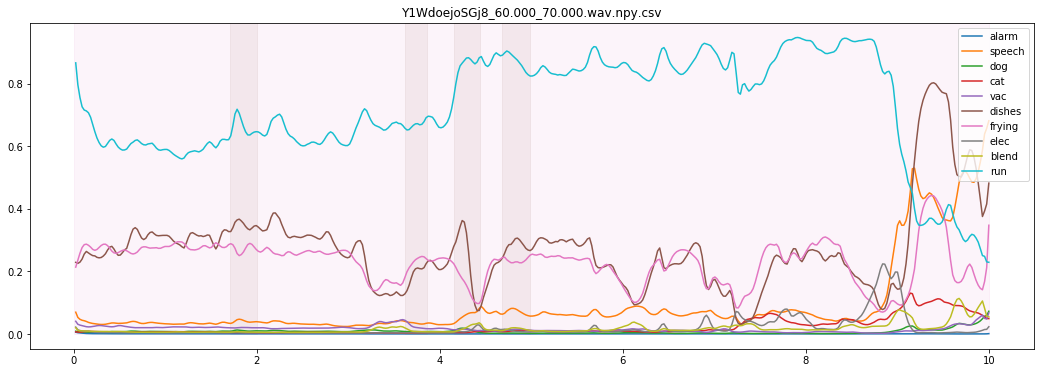

Y21u5DMRvEhs_30.000_40.000.wav.npy
7.843999999999999,9.347000000000001,Dishes



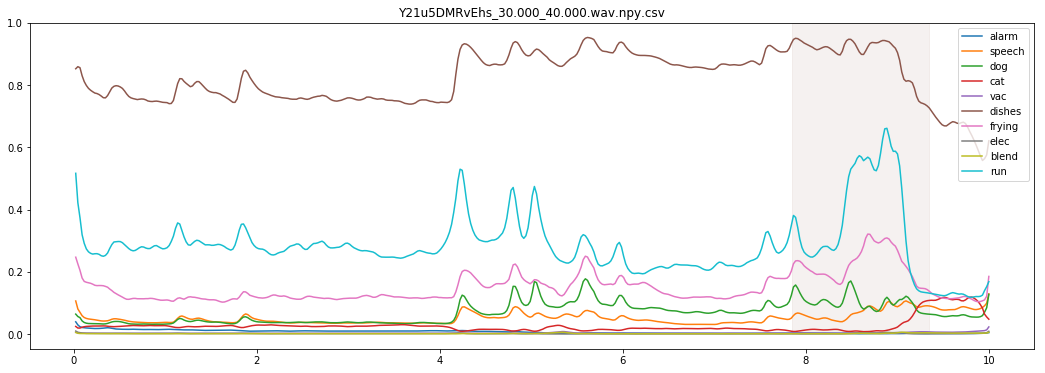

YTUOyN4QdPyY_160.000_170.000.wav.npy
0.0,1.016,Speech
1.9269999999999998,3.09,Speech
3.378,10.0,Frying
5.3,6.727,Speech
6.1339999999999995,6.481,Dishes
8.308,9.095,Speech



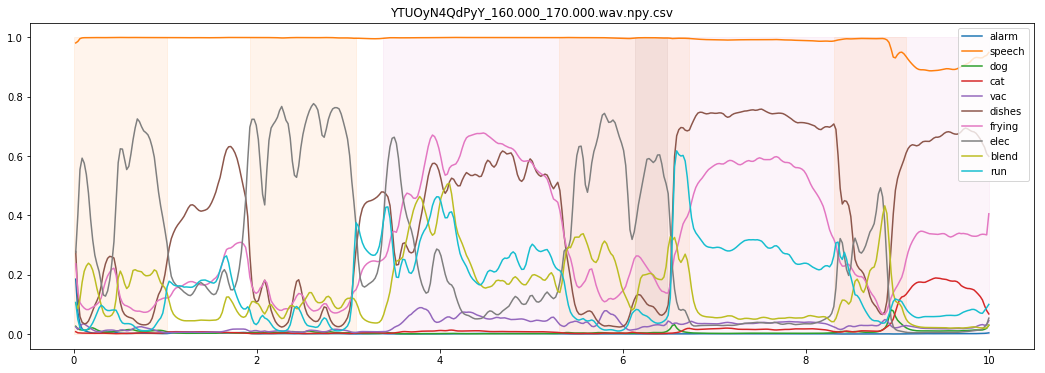

Y2DF8mtDke8k_460.000_470.000.wav.npy
0.0,10.0,Frying
1.218,1.4680000000000002,Dishes
1.893,2.263,Dishes
2.827,7.98,Speech
3.11,3.592,Dishes
3.7969999999999997,4.103,Dishes
3.7969999999999997,4.492,Dishes
4.192,4.492,Dishes
7.98,8.23,Dishes
7.98,8.617,Dishes
8.367,8.617,Dishes
8.797,10.0,Dishes



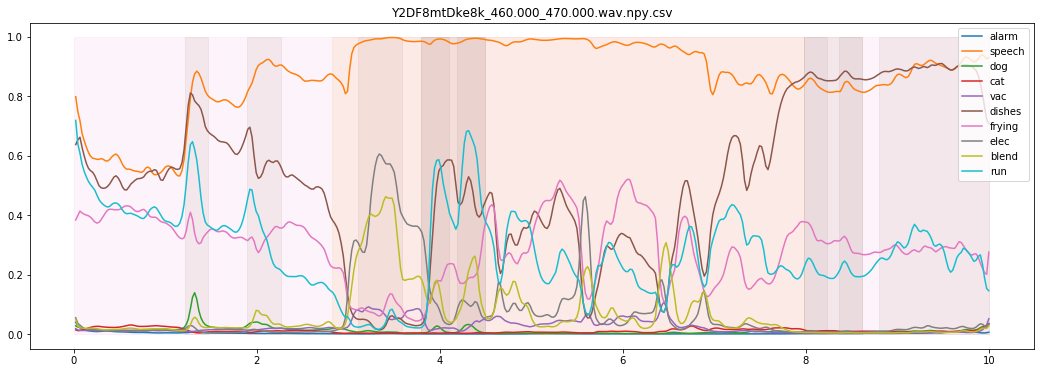

1

In [95]:
for i, filename in enumerate(featTestList):
    if filename[:-4] in fileToAnalyse:
        clip = prediction[i]
        file = featTestList[i]
        nbFrame = prediction.shape[1]
        frameLength = 10 / nbFrame
        print(file)
        rawBoundaries = getClasses(file)
        print(rawBoundaries)

        classes = "time,Alarm_bell_ringing,Speech,Dog,Cat,Vacuum_cleaner,Dishes,Frying,Electric_shaver_toothbrush,Blender,Running_water".split(",")
        output = "time,Alarm_bell_ringing,Speech,Dog,Cat,Vacuum_cleaner,Dishes,Frying,Electric_shaver_toothbrush,Blender,Running_water\n"

        with open(file + ".csv", "w") as toSave:
            frameCounter = 0
            for frame in clip:
                frameCounter += 10 / nbFrame
                output += "%.4f," % frameCounter
                for cls in frame:
                    output += "%.4f," % cls
                output += "\n"
            toSave.write(output)

        display(file + ".csv", patches="test", curve=None)
        
# clean the CSV files
call(["rm", "*.csv"])

In [96]:
def evaluate(evaluation):
    # write the evaluation on the disk
    print("perform evaluation ...")
    with open("perso_eval.csv", "w") as f:
        f.write("filename\tonset\toffset\tevent_label\n")
        f.write(evaluation)

    perso_event_list = MetaDataContainer()
    perso_event_list.load(filename="perso_eval.csv")

    ref_event_list = MetaDataContainer()
    ref_event_list.load(filename="../../meta/test.csv")

    event_based_metric = event_based_evaluation(ref_event_list, perso_event_list)
    print(event_based_metric)

e = Encoder()
print("encoding results ...")
segments = e.encode(prediction, method="hysteresis", high=0.4, low=0.4, smooth="smoothMovingAvg")
evaluation = e.parse(segments, featTestList)
evaluate(evaluation)

encoding results ...
Smooting using the smooth moving average algorithm
perform evaluation ...
Event based metrics (onset-offset)
  Evaluated length                  : 2616.88 sec
  Evaluated files                   : 288 
  Evaluate onset                    : True 
  Evaluate offset                   : True 
  T collar                          : 200.00 ms
  Offset (length)                   : 20.00 %

  Overall metrics (micro-average)
  F-measure
    F-measure (F1)                  : 4.26 %
    Precision                       : 3.35 %
    Recall                          : 5.85 %
  Error rate
    Error rate (ER)                 : 2.55 
    Substitution rate               : 0.08 
    Deletion rate                   : 0.86 
    Insertion rate                  : 1.61 

  Class-wise average metrics (macro-average)
  F-measure
    F-measure (F1)                  : 4.77 %
    Precision                       : 3.44 %
    Recall                          : 11.28 %
  Error rate
    Error rate (E